# Basic fitting for hyperfine beat (stage 1 bootstrap)

From prior work and data:

- Forbes, R. et al. (2018) ‘Quantum-beat photoelectron-imaging spectroscopy of Xe in the VUV’, Physical Review A, 97(6), p. 063417. Available at: https://doi.org/10.1103/PhysRevA.97.063417. arXiv: http://arxiv.org/abs/1803.01081, Authorea (original HTML version): https://doi.org/10.22541/au.156045380.07795038
- Data (OSF): https://osf.io/ds8mk/
- [Quantum Metrology with Photoelectrons (Github repo)](https://github.com/phockett/Quantum-Metrology-with-Photoelectrons), particularly the [Alignment 3 notebook](https://github.com/phockett/Quantum-Metrology-with-Photoelectrons/blob/master/Alignment/Alignment-3.ipynb). Functions from this notebook have been incorporated in the current project, under `qbanalysis.hyperfine`.

For basic fitting, try a stage 1 style bootstrap. In this case, set (arbitrary) parameters per final state for the probe, and fit these plus the hyperfine beat model parameters. This should allow for a match to a single set of hyperfine parameters for all observables.

- 14/06/24: basic fit for L=4/ROI-0 data working with Scipy. Next should add ionization model and use all states...
   - Xarray wrapper may be neater? See https://docs.xarray.dev/en/latest/generated/xarray.DataArray.curvefit.html#xarray.DataArray.curvefit
   - 16/06/24: A,B param determination with Scipy.least_squares working. Seems like overkill, but other methods not very flexible? Currently pass Xarray data for calcs, with wrappers for Scipy. Quite annoying.
   - TODO: try PD-based calc, should actually be easier in this case.

## Setup fitting model

Follow the modelling notebook, but wrap functions for fitting.

### Imports

In [1]:
# Load packages
# Main functions used herein from qbanalysis.hyperfine
from qbanalysis.hyperfine import *
import numpy as np
from epsproc.sphCalc import setBLMs

from pathlib import Path

dataPath = Path('/tmp/xe_analysis')
# dataTypes = ['BLMall', 'BLMerr', 'BLMerrCycle']   # Read these types, should just do dir scan here.

# # Read from HDF5/NetCDF files
# # TO FIX: this should be identical to loadFinalDataset(dataPath), but gives slightly different plots - possibly complex/real/abs confusion?
# dataDict = {}
# for item in dataTypes:
#     dataDict[item] = IO.readXarray(fileName=f'Xe_dataset_{item}.nc', filePath=dataPath.as_posix()).real
#     dataDict[item].name = item

# Read from raw data files
from qbanalysis.dataset import loadFinalDataset
dataDict = loadFinalDataset(dataPath)

# Use Pandas and load Xe local data (ODS)
# These values were detemermined from the experimental data as detailed in ref. [4].
from qbanalysis.dataset import loadXeProps
xeProps = loadXeProps()

2024-06-17 12:45:47.933 | INFO     | qbanalysis.config:<module>:11 - PROJ_ROOT path is: /home/jovyan/code-share/github-share/Quantum-Beat_Photoelectron-Imaging_Spectroscopy_of_Xe_in_the_VUV
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


* sparse not found, sparse matrix forms not available. 
* natsort not found, some sorting functions not available. 


* Setting plotter defaults with epsproc.basicPlotters.setPlotters(). Run directly to modify, or change options in local env.


* Set Holoviews with bokeh.
* pyevtk not found, VTK export not available. 
2024-06-17 12:45:53.569 | INFO     | qbanalysis.hyperfine:<module>:28 - Using uncertainties modules, Sympy maths functions will be forced to float outputs.
2024-06-17 12:45:53.637 | INFO     | qbanalysis.dataset:loadDataset:244 - Loaded data cpBasex_results_cycleSummed_rot90_quad1_ROI_results_with_FT_NFFT1024_hanningWindow_270717.mat.
2024-06-17 12:45:53.682 | INFO     | qbanalysis.dataset:loadDataset:244 - Loaded data cpBasex_results_allCycles_ROIs_with_FTs_NFFT1024_hanningWindow_270717.mat.
2024-06-17 12:45:53.990 | INFO     | qbanalysis.dataset:loadFinalDataset:220 - Processed data to Xarray OK.
2024-06-17 12:45:54.034 | INFO     | qbanalysis.dataset:loadXeProps:71 - Loaded Xe data from /home/jovyan/code-share/github-share/Quantum-Beat_Photoelectron-Imaging_Spectroscopy_of_Xe_in_the_VUV/dataLocal/Xe_data_table_fixedFractions.ods.

**Xe measured level splittings and the hyperfine constants.**
Statistical uncer

A/MHz      B/MHz   Splitting/cm−1
Isotope I   F   F′                                        
129     0.5 0.5 1.5  -5723+/-9  nan+/-nan  0.2863+/-0.0005
131     1.5 1.5 0.5  1697+/-30     -8+/-7  0.0855+/-0.0010
            2.5 1.5  1697+/-30     -8+/-7  0.1411+/-0.0029
                0.5  1697+/-30     -8+/-7  0.2276+/-0.0029

### Init parameters

Here use `xeProps` to set and define fit paramters. Note in the original work the splittings were determined by FT of the data, and A, B parameters via Eqn. 2 therein.

TODO: may want to use lmfit here for more flexibility.

In [9]:
# Set splittings
fitParamsCol = 'Splitting/cm−1'
xePropsFit = xeProps.copy()

xeSplittings = xePropsFit[fitParamsCol].to_numpy()

In [3]:
# # Test beat model with changed params...
# xeSplittings = np.random.randn(4)
# xeSplittings

array([ 0.08182867, -0.28475379,  1.44554767, -0.27944337])

In [4]:
# xePropsFit[fitParamsCol] = 0.1*np.abs(xeSplittings)
# xePropsFit

A/MHz      B/MHz  Splitting/cm−1
Isotope I   F   F′                                       
129     0.5 0.5 1.5  -5723+/-9  nan+/-nan        0.008183
131     1.5 1.5 0.5  1697+/-30     -8+/-7        0.028475
            2.5 1.5  1697+/-30     -8+/-7        0.144555
                0.5  1697+/-30     -8+/-7        0.027944

In [10]:
plotOpts = {'width':800}
# plotHyperfineModel(computeModelSum(modelDict))
# computeModelSum(modelDict)

# from epsproc.util.conversion import datasetStack

# datasetStack(computeModelSum(modelDict), )
modelDict = computeModel(xePropsFit)
modelDictSum = computeModelSum(modelDict)

# stackDim = 'iso'

# dataDict[key].expand_dims({stackDim:[n]})
# xrDA = xr.concat([dataDict[k].expand_dims({stackDim:[k]}) for k in dataDict.keys()] , stackDim)

# plotHyperfineModel(xrDA).overlay('iso')
    
    
modelDA = stackModelToDA(modelDictSum)  #.to_dataset()
plotHyperfineModel(modelDA, **plotOpts).opts(title="Isotope comparison + sum")

:Overlay
   .NdOverlay.I  :NdOverlay   [K,Q,Isotope]
      :Spread   [t]   (sum,sum_std)
   .NdOverlay.II :NdOverlay   [K,Q,Isotope]
      :Curve   [t]   (sum,sum_std)

In [69]:
splitUncertaintiesToDataset(modelDA).dims

Frozen({'Isotope': 3, 't': 200, 'TKQ': 2})

In [71]:
dataIn = modelDA
DS = splitUncertaintiesToDataset(dataIn)
hvDS = hvPlotters.hv.Dataset(DS.unstack())
overlay=['K','Q','Isotope']
hvDS.to(hvPlotters.hv.Spread, kdims = ['t']).overlay(overlay).opts(title = dataIn.name) * hvDS.to(hvPlotters.hv.Curve, kdims = ['t']).overlay(overlay)

:Overlay
   .NdOverlay.I  :NdOverlay   [K,Q,Isotope]
      :Spread   [t]   (sum,sum_std)
   .NdOverlay.II :NdOverlay   [K,Q,Isotope]
      :Curve   [t]   (sum,sum_std)

In [63]:
plotHyperfineModel(modelDA.to_array())

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_15357/3461928158.py", line 1, in <module>
    plotHyperfineModel(modelDA.to_array())
  File "/home/jovyan/code-share/github-share/Quantum-Beat_Photoelectron-Imaging_Spectroscopy_of_Xe_in_the_VUV/qbanalysis/hyperfine.py", line 660, in plotHyperfineModel
    if unFlag:
  File "/home/jovyan/code-share/github-share/Quantum-Beat_Photoelectron-Imaging_Spectroscopy_of_Xe_in_the_VUV/qbanalysis/hyperfine.py", line 638, in splitUncertaintiesToDataset
  File "/opt/conda/lib/python3.10/site-packages/xarray/core/dataarray.py", line 571, in to_dataset
    result = self._to_dataset_whole(name)
  File "/opt/conda/lib/python3.10/site-packages/xarray/core/dataarray.py", line 515, in _to_dataset_whole
    raise ValueError(
ValueError: unable to convert unnamed DataArray to a Dataset without

In [62]:
stackDim = 'TKQ'
# xrDA = xr.concat([modelDict[k].to_dataset() for k in modelDict.keys()], stackDim)
xrDA = xr.merge([modelDict[k].to_dataset() for k in modelDict.keys()])
xrDA.to_array()

<xarray.DataArray (variable: 2, t: 200, TKQ: 2)>
array([[[0.19245008972987523+/-0, -0.2721655269759086+/-0],
        [0.19245008972987523+/-0,
         -0.27189048519119297+/-1.1007673886223377e-05],
        [0.19245008972987523+/-0,
         -0.2710661936823629+/-2.1981975761984513e-05],
        [0.19245008972987523+/-0,
         -0.26969515145739575+/-3.288963479088334e-05],
        [0.19245008972987523+/-0,
         -0.2677815151106775+/-4.3697582177914355e-05],
        [0.19245008972987523+/-0,
         -0.26533108622143753+/-5.4373051424269224e-05],
        [0.19245008972987523+/-0,
         -0.26235129376507743+/-6.488367766566682e-05],
        [0.19245008972987523+/-0,
         -0.2588511715907152+/-7.51975957930461e-05],
        [0.19245008972987523+/-0,
         -0.2548413310332278+/-8.528353705814916e-05],
        [0.19245008972987523+/-0,
         -0.25033392874282295+/-9.511092387111462e-05],
        [0.19245008972987523+/-0,
...
        [0.1924500897298752+/-0,
         -0.07276027219043842+/-0.0001358485744074869],
        [0.1924500897298752+/-0,
         -0.06647554728904878+/-0.00011553763153916439],
        [0.1924500897298752+/-0,
         -0.06122643968391612+/-9.458225938046711e-05],
        [0.1924500897298752+/-0,
         -0.057016862245533546+/-7.410490355048685e-05],
        [0.1924500897298752+/-0,
         -0.05379648520338179+/-5.51472791358643e-05],
        [0.1924500897298752+/-0,
         -0.05146582397624939+/-3.8628931472059034e-05],
        [0.1924500897298752+/-0,
         -0.04988326900224412+/-2.5311168458955907e-05],
        [0.1924500897298752+/-0,
         -0.04887375577868649+/-1.5767664805762324e-05],
        [0.1924500897298752+/-0,
         -0.04823871437083252+/-1.036279091019189e-05],
        [0.1924500897298752+/-0,
         -0.04776689201975056+/-9.238435000948482e-06]]], dtype=object)
Coordinates:
  * t         (t) object 0.00+/-0.10 5.00+/-0.10 ... 990.00+/-0.10 995.00+/-0.10
  * TKQ       (TKQ) MultiIndex
  - K         (TKQ) int64 0 2
  - Q         (TKQ) int64 0 0
  * variable  (variable) <U5 '129Xe' '131Xe'

In [47]:
# modelDictSum['sum'].to_dataset() + modelDictSum['131Xe'].to_dataset()
# testDS = modelDictSum['sum'].expand_dims({'iso':['sum']}).to_dataset() 
# testDS

# xr.combine_by_coords(modelDictSum)
xr.concat(modelDictSum, dim='iso')

TypeError: can only concatenate xarray Dataset and DataArray objects, got <class 'str'>

In [29]:
modelDA

<xarray.Dataset>
Dimensions:  (Isotope: 3, t: 200, TKQ: 2)
Coordinates:
  * Isotope  (Isotope) <U5 'sum' '129Xe' '131Xe'
  * t        (t) object 0.00+/-0.10 5.00+/-0.10 ... 990.00+/-0.10 995.00+/-0.10
  * TKQ      (TKQ) MultiIndex
  - K        (TKQ) int64 0 2
  - Q        (TKQ) int64 0 0
Data variables:
    sum      (Isotope, t, TKQ) object 0.192450089729875206679+/-0.00000000000...

In [9]:
modelDict = computeModel(xePropsFit)
modelSum = computeModelSum(modelDict)['sum'] 
plotOpts = {'width':800}
(plotHyperfineModel(modelDict['129Xe'], **plotOpts) * plotHyperfineModel(modelDict['131Xe'], **plotOpts) * plotHyperfineModel(modelSum, **plotOpts)).opts(title="Isotope comparison + sum")


:Overlay
   .NdOverlay.I   :NdOverlay   [K,Q]
      :Spread   [t]   (129Xe,129Xe_std)
   .NdOverlay.II  :NdOverlay   [K,Q]
      :Curve   [t]   (129Xe,129Xe_std)
   .NdOverlay.III :NdOverlay   [K,Q]
      :Spread   [t]   (131Xe,131Xe_std)
   .NdOverlay.IV  :NdOverlay   [K,Q]
      :Curve   [t]   (131Xe,131Xe_std)
   .NdOverlay.V   :NdOverlay   [K,Q]
      :Spread   [t]   (sum,sum_std)
   .NdOverlay.VI  :NdOverlay   [K,Q]
      :Curve   [t]   (sum,sum_std)

In [6]:
# Test with ROI 0, l=4 case first...
dataDict['BLMall'].sel({'ROI':0,'l':4}).squeeze().hvplot()  #.line(x='t')

:Curve   [t]   (BLM input 0)

In [7]:
# v2 packaged
from qbanalysis.basic_fitting import *

    
# Test fit...

# Fit to residuals, just set to zero (NOT required for least_squares)
yData = xr.zeros_like(dataDict['BLMall'].sel({'ROI':0,'l':4}))
yData = yData.values

import scipy
# x0 = np.abs(np.random.random(4))  # Randomise inputs

xePropsFit = xeProps.copy()
x0 = unumpy.nominal_values(xePropsFit[fitParamsCol].to_numpy())  # Test with previous vals

fitOut = scipy.optimize.least_squares(calcFitModel, x0, bounds = (0.01,0.5),
                                      kwargs = {'xePropsFit':xePropsFit, 'dataDict':dataDict})
fitOut.success

NameError: name 'logger' is not defined

In [241]:
# Using Scipy, the fit details are in fitOut, and results in fitOut.x
fitOut.x

array([0.29126303, 0.08466675, 0.1411    , 0.22949392])

In [242]:
fitOut

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 8.541e-07  2.215e-05 ...  3.658e-04  5.021e-04]
           x: [ 2.913e-01  8.467e-02  1.411e-01  2.295e-01]
        cost: 2.3725378584475683e-05
         jac: [[ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
               [-9.299e-04  2.320e-04  0.000e+00 -5.137e-04]
               ...
               [ 5.836e-01 -3.171e-01  0.000e+00  2.142e-01]
               [ 7.487e-01 -3.187e-01  0.000e+00  9.719e-02]]
        grad: [-4.296e-09 -5.315e-08  0.000e+00  4.667e-09]
  optimality: 2.2076459731634488e-08
 active_mask: [0 0 0 0]
        nfev: 23
        njev: 12

In [243]:
# Check results - run model again with best fits
xePropsFit, modelFit, modelFitSum, modelIn, dataIn, res = calcFitModel(fitOut.x, xePropsFit, dataDict, fitFlag=False)

# # Fix splitting value (derived) - NOW IN MAIN ROUTINE
# iso=131
# xePropsFit.loc[(iso,1.5,2.5,1.5), dataCol] = xePropsFit.loc[(iso,1.5,2.5,0.5), dataCol] - xePropsFit.loc[(iso,1.5,1.5,0.5), dataCol]
# xePropsFit

# Fitted model & components
(plotHyperfineModel(modelFit['129Xe'], **plotOpts) * plotHyperfineModel(modelFit['131Xe'], **plotOpts) * plotHyperfineModel(modelFitSum, **plotOpts)).opts(title="Isotope comparison + sum")

:Overlay
   .NdOverlay.I   :NdOverlay   [K,Q]
      :Spread   [t]   (129Xe,129Xe_std)
   .NdOverlay.II  :NdOverlay   [K,Q]
      :Curve   [t]   (129Xe,129Xe_std)
   .NdOverlay.III :NdOverlay   [K,Q]
      :Spread   [t]   (131Xe,131Xe_std)
   .NdOverlay.IV  :NdOverlay   [K,Q]
      :Curve   [t]   (131Xe,131Xe_std)
   .NdOverlay.V   :NdOverlay   [K,Q]
      :Spread   [t]   (sum,sum_std)
   .NdOverlay.VI  :NdOverlay   [K,Q]
      :Curve   [t]   (sum,sum_std)

In [244]:
# Compare fit results with dataset
from qbanalysis.plots import plotFinalDatasetBLMt
# plotFinalDatasetBLMt(**dataDict, **plotOpts) * plotHyperfineModel(modelFitSum, **plotOpts).select(K=2).opts(**plotOpts)
plotHyperfineModel(modelFitSum, **plotOpts).select(K=2).opts(**plotOpts) * plotFinalDatasetBLMt(**dataDict, **plotOpts)

:NdLayout   [l]
   :Overlay
      .NdOverlay.I   :NdOverlay   [K,Q]
         :Spread   [t]   (sum,sum_std)
      .NdOverlay.II  :NdOverlay   [K,Q]
         :Curve   [t]   (sum,sum_std)
      .NdOverlay.III :NdOverlay   [ROI]
         :Spread   [t]   (BLM per cycle,BLM per cycle_std)
      .NdOverlay.IV  :NdOverlay   [ROI]
         :Curve   [t]   (BLM input 0)

In [245]:
# Check new results vs. reference case...
compareResults(xeProps, xePropsFit)

original       fit      diff
Isotope I   F   F′                                      
129     0.5 0.5 1.5  0.2863+/-0.0005  0.291263 -0.004963
131     1.5 1.5 0.5  0.0855+/-0.0010  0.084667  0.000833
            2.5 1.5  0.1411+/-0.0029  0.144827 -0.003727
                0.5  0.2276+/-0.0029  0.229494 -0.001894

In [228]:
xePropsFit

A/MHz      B/MHz  Splitting/cm−1
Isotope I   F   F′                                       
129     0.5 0.5 1.5  -5723+/-9  nan+/-nan        0.291263
131     1.5 1.5 0.5  1697+/-30     -8+/-7        0.084667
            2.5 1.5  1697+/-30     -8+/-7        0.141100
                0.5  1697+/-30     -8+/-7        0.229494

In [246]:
# # Fix splitting value (derived) - NOW IN MAIN ROUTINE
# iso=131
# xePropsFit.loc[(iso,1.5,2.5,1.5), dataCol] = xePropsFit.loc[(iso,1.5,2.5,0.5), dataCol] - xePropsFit.loc[(iso,1.5,1.5,0.5), dataCol]
# xePropsFit

### Determine A & B parameters

Previously fitted in Matlab with cffit tool, see `jake-home/tmp/xe_analysis_2024_scratch/Xe_hyperfine_cftool_fit_code_041217.m`.

From the measurements, the hyperfine coupling constants can be determined by fitting to the usual form (see, e.g., ref. \cite{D_Amico_1999}):
\begin{equation}
\Delta E_{(F,F-1)}=AF+\frac{3}{2}BF\left(\frac{F^{2}+\frac{1}{2}-J(J+1)-I(I+1)}{IJ(2J-1)(2I-1)}\right)
\end{equation}

Note, for $^{129}\rm{Xe}$, $\Delta E_{(F,F-1)}=AF$ only ($B=0$).

### Quick test with sklearn (linear)

In [60]:
# Xe129, dE(F,F-1)=AF
# xePropsFit[[xePropsFit.xs((129)),'A/MHz']]  #['A/MHz']= 30

cmToMHz = 29979.2458
dataCol = 'Splitting/cm−1'
qnDF = xePropsFit.loc[(129)].index.to_frame()  # Convert to DF for easy Q.N./index value retrieval
xePropsFit.loc[(129), 'A/MHz'] = (xePropsFit.loc[(129), dataCol]/qnDF['F′']).values * cmToMHz
xePropsFit                                                                                                         

A/MHz      B/MHz  Splitting/cm−1
Isotope I   F   F′                                         
129     0.5 0.5 1.5  5821.230642  nan+/-nan        0.291263
131     1.5 1.5 0.5    1697+/-30     -8+/-7        0.084667
            2.5 1.5    1697+/-30     -8+/-7        0.141100
                0.5    1697+/-30     -8+/-7        0.229494

In [66]:
xePropsFit.xs(131)[dataCol]

I    F    F′ 
1.5  1.5  0.5    0.084667
     2.5  1.5    0.144827
          0.5    0.229494
Name: Splitting/cm−1, dtype: float64

In [82]:
xePropsFit.xs(iso)[dataCol].to_numpy()

array([0.08466675, 0.14482717, 0.22949392])

In [80]:
qnDF['F'].to_numpy()

array([1.5, 2.5, 2.5])

In [86]:
# Xe131
iso=131
qnDF = xePropsFit.loc[(iso)].index.to_frame()  # Convert to DF for easy Q.N./index value retrieval

# Fix splitting value (derived)
xePropsFit.loc[(iso,1.5,2.5,1.5), dataCol] = xePropsFit.loc[(iso,1.5,2.5,0.5), dataCol] - xePropsFit.loc[(iso,1.5,1.5,0.5), dataCol]
xePropsFit


# Quick test with linear regression
# https://realpython.com/linear-regression-in-python/
# Probably want scipy.curve_fit here though, with function defined.
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Quick test, only need 2 of these values, but should be more careful here...!
x=qnDF['F'][0:2].to_numpy().reshape(-1,1)
y=xePropsFit.xs(iso)[dataCol][0:2].to_numpy()
model.fit(x,y)
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

# TODO: check old work for method (not in Matlab code...?)
# TODO: other methods? Scipy or Xarray...?
# https://docs.xarray.dev/en/latest/generated/xarray.DataArray.curvefit.html#xarray.DataArray.curvefit

coefficient of determination: 1.0
intercept: -0.005573868903624241
slope: [0.06016042]


### Use Xarray wrapper - should be easier... V2: extract from PD, then XR

In [247]:
# xeData = xePropsFit.to_xarray()

# xePropsFit.s
dataCol = 'Splitting/cm−1'
xePropsFit.xs(131)[dataCol]
# unstack .to_xarray()

I    F    F′ 
1.5  1.5  0.5    0.084667
     2.5  1.5    0.144827
          0.5    0.229494
Name: Splitting/cm−1, dtype: float64

In [248]:
# dEXR.loc[{'Isotope':131,'F':2.5,'F′':0.5, 'I':1.5}]

In [249]:
# NEW APPROACH - set up specific DA for fitting...
# THIS will return required vals only.
xeSubSel = xePropsFit.xs(131)[dataCol][0:2].droplevel('F′').to_xarray()  # for f' too?
A = xePropsFit.xs(131)['A/MHz'][0:2].droplevel('F′').to_xarray()
B = xePropsFit.xs(131)['B/MHz'][0:2].droplevel('F′').to_xarray()

dESubSel = dEv2(xeSubSel,A,B)
dESubSel

<xarray.DataArray (I: 1, F: 2)>
array([[0.08530902, 0.14138114]])
Coordinates:
  * I        (I) float64 1.5
  * F        (F) float64 1.5 2.5

In [250]:
xeSubSel.squeeze().hvplot()

:Curve   [F]   (Splitting/cm−1)

In [251]:
xeSubSel.squeeze() - dESubSel

<xarray.DataArray (F: 2, I: 1)>
array([[-0.00064226],
       [ 0.00344603]])
Coordinates:
  * I        (I) float64 1.5
  * F        (F) float64 1.5 2.5

In [252]:
# With Scipy wrapper... test return OK...
print(dEv2WrapperScipy([2000,0],xeDataIn=xeSubSel))
print(dEv2WrapperScipy([1697,0],xeDataIn=xeSubSel))
print(dEv2WrapperScipy([1697,-8],xeDataIn=xeSubSel))

[0.00023724 0.00048202]
[5.85572405e-08 1.09733356e-05]
[4.12501694e-07 1.18751102e-05]


In [266]:
# # Ah, can't pass additional args to curvefit in any case...????
# dsFit = dESubSel.curvefit(

#     coords=dESubSel.F,
    
#     # reduce_dims="I",

#     func=dEv2Wrapper,

#     bounds={"A": (1000, 2000), "B": (-15, 15)},
    
#     param_names=["A","B"],
    
#     kwargs={'xeDataIn':dESubSel}

# )

# USE WRAPPER FOR SCIPY DIRECTLY... WORKING...
#
# Defaults give [1718.15579161,   -2.19752871], [1663.67627212,    4.42848128], [ 1.69247409e+03, -1.49524345e-01]
# Seems more dependent on x0in than tolerances...? Could do with more points?
# Sets B to ~0 if bounded at 0, so -ve definitely good it seems, although not well defined?
#
# UPDATE: had mixed new and old values... now fixed...
#  [1729.31918052,   37.13028214]  # Seems pretty consistent vs. x0in.
#
# x0in = [2000,0]
# x0in = [1500, 0]
x0in = np.random.rand(2)

fitOut = scipy.optimize.least_squares(dEv2WrapperScipy, x0in, bounds = ([0,-100],[2500,100]),
                                      kwargs = {'xeDataIn':xeSubSel},
                                      verbose = 2,
                                      xtol=1e-12,ftol=1e-12,gtol=1e-18)

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_lsq/least_squares.py:111: UserWarning: Setting `gtol` below the machine epsilon (2.22e-16) effectively disables the corresponding termination condition.
  warn("Setting `{}` below the machine epsilon ({:.2e}) effectively "


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4546e-04                                    1.42e-03    
       1              2         2.4383e-04      1.63e-06       2.88e+00       1.41e-03    
       2              3         2.4061e-04      3.23e-06       5.75e+00       1.39e-03    
       3              4         2.3426e-04      6.35e-06       1.15e+01       1.36e-03    
       4              5         2.2196e-04      1.23e-05       2.29e+01       1.29e-03    
       5              6         1.9893e-04      2.30e-05       4.56e+01       1.17e-03    
       6              7         1.5864e-04      4.03e-05       9.04e+01       9.49e-04    
       7              8         9.7666e-05      6.10e-05       1.77e+02       6.09e-04    
       8              9         3.1263e-05      6.64e-05       3.41e+02       2.18e-04    
       9             10         4.3616e-06      2.69e-05       4.01e+02       3.87e-05    

In [267]:
fitOut

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 7.926e-13  1.815e-12]
           x: [ 1.729e+03  3.713e+01]
        cost: 1.961187787631739e-24
         jac: [[-8.902e-11  8.909e-11]
               [-2.245e-10 -4.494e-11]]
        grad: [-4.780e-22 -1.095e-23]
  optimality: 3.684396735324347e-19
 active_mask: [0 0]
        nfev: 26
        njev: 26

In [268]:
fitOut.x

array([1729.28061822,   37.1347838 ])

In [167]:
# 17/06/24: now in basic_fitting.py

# # V2, testing subselected PD array > Xr
# # Calculate dE for Xarray input - in this case all coords should match in size...
# # A,B can be Xarray or scalar
# # def dEv2(xeDataIn, A, B, units = 'cm-1'):
# def dEv2(xeDataIn, A, B):
#     """
#     the hyperfine coupling constants can be determined by fitting to the usual form (see, e.g., ref. \cite{D_Amico_1999}):
#     \begin{equation}
#     \Delta E_{(F,F-1)}=AF+\frac{3}{2}BF\left(\frac{F^{2}+\frac{1}{2}-J(J+1)-I(I+1)}{IJ(2J-1)(2I-1)}\right)
#     \end{equation}
    
#     NOTE: units currently set for return values only.
#     """
#     # for iso in xeData.Isotope:
#     #     print(item)
#     units = 'cm-1'
#     cmToMHz = 29979.2458
    
#     # Isotope terms
#     J=1
#     I=xeDataIn.I
#     c1=0.5-J*(J+1)-I*(I+1)
#     c2=I*J*(2*J-1)*(2*I-1)
    
#     # A/B terms
#     F = xeDataIn.F
#     # F = xeData['F′']  # TODO: fix 129 ordering, needs F,F' swapped! (Or enforce selection here...)
#                         # Or swap on max value, or unique values... 
#                         # Or check on dF, xeData.F - xeData['F′'] ...?
#     # This works, but have some redundant values still
#     # Ffixed = xr.where(xeData.F > xeData['F′'], xeData.F, xeData['F′'])  # Check greater
#     # F = Ffixed[:,1]
    
#     # Try unique vals only... Breaks 129 case...
#     # F = xeData.F.where(xeData.F > 1)
    
#     # Deltas... filter on these at return?
#     # dF = xeData.F - xeData['F′']
    
    
#     t1 = A*F  #* np.sign(dF)
    
#     # For Xr case avoid Nan propagation
#     if isinstance(B, xr.DataArray):
#         if unFlag:
#             B = xrUnFillna(B)
#         else:
#             B = B.fillna(0)
        
        
#     t2 = (3/2)*B*((F**2 + c1)/c2)
#     t2 = t2.fillna(0)
    
#     # return t1,t2,t1+t2
    
#     if units == 'MHz':
#         dEout = t1+t2
#     elif units == 'cm-1':
#         dEout = (t1+t2)*(1/cmToMHz)

#     # Check allowed terms...?
#     # dEout = dEout.where(np.abs(dF)<2,np.nan)
        
        
#     # TODO: general fix for F-F' > 1..?
#     # dEXR.where(dEXR.F - dEXR['F′'] > 1)
#     # Quick fix here for Xe131 case only
#     # dEout.sel({'F':
#     # dEout.loc[{'Isotope':131,'F':2.5,'F′':0.5, 'I':1.5}] = dEout.sel({'Isotope':131,'F':1.5,'F′':0.5, 'I':1.5}) + dEout.sel({'Isotope':131,'F':2.5,'F′':1.5, 'I':1.5})
    
#     if unFlag:
#         dEout.values = unumpy.nominal_values(dEout)
        
#     return dEout


# def dEv2Wrapper(xeDataInNP, A, B, xeDataIn):
#     """
#     Thin wrapper for xr.curvefit.
    
#     Just swap NP data as passed for XR data to use existing function
#     """
    
#     dEOut = dEv2(xeDataIn, A, B)
    
#     return dEout

    
# def dEv2WrapperScipy(x0,xeDataIn=None):
#     """
#     ... and wrap for Scipy least_squares...
#     """
    
#     dEOut = dEv2(xeDataIn, x0[0], x0[1])
    
#     res = ((xeDataIn - dEOut)**2).squeeze()
    
#     return res.values

    
# def xrUnFillna(xrData):
#     """
#     Implement xr.fillna for Uncertainties data types.
#     """
    
#     return xrData.where(~unumpy.isnan(xrData),0)

### Use Xarray wrapper - should be easier... V1: pure Xr, lots of redun

In [13]:
xeData = xePropsFit.to_xarray()
xeData

<xarray.Dataset>
Dimensions:         (Isotope: 2, I: 2, F: 3, F′: 2)
Coordinates:
  * Isotope         (Isotope) int64 129 131
  * I               (I) float64 0.5 1.5
  * F               (F) float64 0.5 1.5 2.5
  * F′              (F′) float64 0.5 1.5
Data variables:
    A/MHz           (Isotope, I, F, F′) object nan -5723+/-9 ... 1697+/-30
    B/MHz           (Isotope, I, F, F′) object nan nan+/-nan ... -8+/-7 -8+/-7
    Splitting/cm−1  (Isotope, I, F, F′) float64 nan 0.2913 nan ... 0.2295 0.1411

In [14]:
xeData.F

<xarray.DataArray 'F' (F: 3)>
array([0.5, 1.5, 2.5])
Coordinates:
  * F        (F) float64 0.5 1.5 2.5

In [98]:
# 17/06/24: now in basic_fitting.py

# # V1, assumes full PD array > Xr
# # Calculate dE for Xarray input - in this case all coords should match in size...
# # A,B can be Xarray or scalar
# def dE(xeDataIn, A, B, units = 'cm-1'):
#     """
#     the hyperfine coupling constants can be determined by fitting to the usual form (see, e.g., ref. \cite{D_Amico_1999}):
#     \begin{equation}
#     \Delta E_{(F,F-1)}=AF+\frac{3}{2}BF\left(\frac{F^{2}+\frac{1}{2}-J(J+1)-I(I+1)}{IJ(2J-1)(2I-1)}\right)
#     \end{equation}
    
#     NOTE: units currently set for return values only.
#     """
#     # for iso in xeData.Isotope:
#     #     print(item)
#     cmToMHz = 29979.2458
    
#     # Isotope terms
#     J=1
#     I=xeDataIn.I
#     c1=0.5-J*(J+1)-I*(I+1)
#     c2=I*J*(2*J-1)*(2*I-1)
    
#     # A/B terms
#     # F = xeDataIn.F
#     # F = xeData['F′']  # TODO: fix 129 ordering, needs F,F' swapped! (Or enforce selection here...)
#                         # Or swap on max value, or unique values... 
#                         # Or check on dF, xeData.F - xeData['F′'] ...?
#     # This works, but have some redundant values still
#     Ffixed = xr.where(xeData.F > xeData['F′'], xeData.F, xeData['F′'])  # Check greater
#     F = Ffixed[:,1]
    
#     # Try unique vals only... Breaks 129 case...
#     # F = xeData.F.where(xeData.F > 1)
    
#     # Deltas... filter on these at return?
#     dF = xeData.F - xeData['F′']
    
    
#     t1 = A*F* np.sign(dF)
    
#     # For Xr case avoid Nan propagation
#     if isinstance(B, xr.DataArray):
#         if unFlag:
#             B = xrUnFillna(B)
#         else:
#             B = B.fillna(0)
        
        
#     t2 = (3/2)*B*((F**2 + c1)/c2)
#     t2 = t2.fillna(0)
    
#     # return t1,t2,t1+t2
    
#     if units == 'MHz':
#         dEout = t1+t2
#     elif units == 'cm-1':
#         dEout = (t1+t2)*(1/cmToMHz)

#     # Check allowed terms...?
#     dEout = dEout.where(np.abs(dF)<2,np.nan)
        
        
#     # TODO: general fix for F-F' > 1..?
#     # dEXR.where(dEXR.F - dEXR['F′'] > 1)
#     # Quick fix here for Xe131 case only
#     # dEout.sel({'F':
#     # dEout.loc[{'Isotope':131,'F':2.5,'F′':0.5, 'I':1.5}] = dEout.sel({'Isotope':131,'F':1.5,'F′':0.5, 'I':1.5}) + dEout.sel({'Isotope':131,'F':2.5,'F′':1.5, 'I':1.5})
    
    
#     return dEout

# def xrUnFillna(xrData):
#     """
#     Implement xr.fillna for Uncertainties data types.
#     """
    
#     return xrData.where(~unumpy.isnan(xrData),0)

In [99]:
Ffixed = xr.where(xeData.F > xeData['F′'], xeData.F, xeData['F′'])
Ffixed[:,1]

<xarray.DataArray (F: 3)>
array([1.5, 1.5, 2.5])
Coordinates:
  * F        (F) float64 0.5 1.5 2.5
    F′       float64 1.5

In [100]:
xeData.F.where(xeData.F > 1)

<xarray.DataArray 'F' (F: 3)>
array([nan, 1.5, 2.5])
Coordinates:
  * F        (F) float64 0.5 1.5 2.5

In [101]:
dF = xeData.F - xeData['F′']
xeData.where(np.abs(dF)<2,0)
dF

<xarray.DataArray (F: 3, F′: 2)>
array([[ 0., -1.],
       [ 1.,  0.],
       [ 2.,  1.]])
Coordinates:
  * F        (F) float64 0.5 1.5 2.5
  * F′       (F′) float64 0.5 1.5

In [102]:
xeData.F

<xarray.DataArray 'F' (F: 3)>
array([0.5, 1.5, 2.5])
Coordinates:
  * F        (F) float64 0.5 1.5 2.5

In [103]:
dE(xeData,3,10)

<xarray.DataArray (F: 3, F′: 2, I: 2)>
array([[[ 0.        , -0.00050035],
        [-0.0001501 , -0.00065045]],

       [[ 0.0001501 , -0.00035024],
        [ 0.        , -0.00050035]],

       [[        nan,         nan],
        [        inf,  0.00041696]]])
Coordinates:
  * F        (F) float64 0.5 1.5 2.5
  * F′       (F′) float64 0.5 1.5
  * I        (I) float64 0.5 1.5

In [104]:
isinstance(xeData['B/MHz'], xr.DataArray)

True

In [105]:
dEXR = dE(xeData, xeData['A/MHz'], xeData['B/MHz'])

dEXR  #.sel(Isotope=129)

<xarray.DataArray (Isotope: 2, I: 2, F: 3, F′: 2)>
array([[[[nan, 0.2863480975228536+/-0.00045031152851750527],
         [nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan],
         [nan, nan]]],


       [[[nan, nan],
         [nan, nan],
         [nan, nan]],

        [[nan, nan],
         [0.08530901734692739+/-0.0015413585021624558, nan],
         [nan, 0.14138114174973673+/-0.002504453339251554]]]],
      dtype=object)
Coordinates:
  * Isotope  (Isotope) int64 129 131
  * I        (I) float64 0.5 1.5
  * F        (F) float64 0.5 1.5 2.5
  * F′       (F′) float64 0.5 1.5

In [110]:
# Reduce to only required dim for fitting...
dEsub = dEXR.loc[{'Isotope':131,'F':[1.5,2.5],'I':1.5}]  #.dropna()

# dEsub.hvplot.line(x='F')

In [88]:
# dEXR.sel({'Isotope':131,'F':2.5,'F′':0.5, 'I':1.5}) = dEXR.sel({'Isotope':131,'F':1.5,'F′':0.5, 'I':1.5}) + dEXR.sel({'Isotope':131,'F':2.5,'F′':1.5, 'I':1.5})
dEXR.loc[{'Isotope':131,'F':2.5,'F′':0.5, 'I':1.5}] = dEXR.sel({'Isotope':131,'F':1.5,'F′':0.5, 'I':1.5}) + dEXR.sel({'Isotope':131,'F':2.5,'F′':1.5, 'I':1.5})

In [89]:
dEXR.loc[{'Isotope':131, 'I':1.5}].drop('F′')

<xarray.DataArray (F: 3, F′: 2)>
array([[nan, nan],
       [0.08530901734692739+/-0.0015413585021624558, nan],
       [0.22669015909666412+/-0.0029407605411996317,
        0.14138114174973673+/-0.002504453339251554]], dtype=object)
Coordinates:
    Isotope  int64 131
    I        float64 1.5
  * F        (F) float64 0.5 1.5 2.5
Dimensions without coordinates: F′

In [231]:
Ffixed

<xarray.DataArray (F: 3, F′: 2)>
array([[0.5, 1.5],
       [1.5, 1.5],
       [2.5, 2.5]])
Coordinates:
  * F        (F) float64 0.5 1.5 2.5
  * F′       (F′) float64 0.5 1.5

In [232]:
dEXR.loc[{'Isotope':131,'F':2.5,'F′':0.5, 'I':1.5}]

<xarray.DataArray ()>
array(0.22669015909666412+/-0.0029407605411996317, dtype=object)
Coordinates:
    Isotope  int64 131
    I        float64 1.5
    F        float64 2.5
    F′       float64 0.5

In [237]:
dEXR.sel({'Isotope':131,'I':1.5},drop=True) #.flatten()  #.dropna()

<xarray.DataArray (F: 3, F′: 2)>
array([[nan, nan],
       [0.08530901734692739+/-0.0015413585021624558, nan],
       [0.22669015909666412+/-0.0029407605411996317,
        0.14138114174973673+/-0.002504453339251554]], dtype=object)
Coordinates:
  * F        (F) float64 0.5 1.5 2.5
  * F′       (F′) float64 0.5 1.5

In [218]:
dEXR.where(dEXR.F - dEXR['F′'] > 1)

<xarray.DataArray (Isotope: 2, I: 2, F: 3, F′: 2)>
array([[[[nan, nan],
         [nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan],
         [nan, nan]]],


       [[[nan, nan],
         [nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan],
         [0.14138114174973673+/-0.002504453339251554, nan]]]],
      dtype=object)
Coordinates:
  * Isotope  (Isotope) int64 129 131
  * I        (I) float64 0.5 1.5
  * F        (F) float64 0.5 1.5 2.5
  * F′       (F′) float64 0.5 1.5

In [134]:
dE(xeData,0,0)

<xarray.DataArray (F: 3, I: 2)>
array([[nan,  0.],
       [nan,  0.],
       [nan,  0.]])
Coordinates:
  * F        (F) float64 0.5 1.5 2.5
  * I        (I) float64 0.5 1.5

In [143]:
F = xeData.F
xeData['A/MHz'] * F

<xarray.DataArray (Isotope: 2, I: 2, F: 3, F′: 2)>
array([[[[nan, 2910.6153208907326],
         [nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan],
         [nan, nan]]],


       [[[nan, nan],
         [nan, nan],
         [nan, nan]],

        [[nan, nan],
         [2545.5+/-45.0, nan],
         [4242.5+/-75.0, 4242.5+/-75.0]]]], dtype=object)
Coordinates:
  * Isotope  (Isotope) int64 129 131
  * I        (I) float64 0.5 1.5
  * F        (F) float64 0.5 1.5 2.5
  * F′       (F′) float64 0.5 1.5

In [151]:
B = xeData['B/MHz']

J=1
I=xeData.I
c1=0.5-J*(J+1)-I*(I+1)
c2=I*J*(2*J-1)*(2*I-1)

# For Xr case avoid Nan propagation
if isinstance(B, xr.DataArray):
    B = B.fillna(0)

t2 = (3/2)*B*((F**2 + c1)/c2)
t2 = t2.fillna(0)
t2

<xarray.DataArray (Isotope: 2, I: 2, F: 3, F′: 2)>
array([[[[0, nan+/-nan],
         [0, 0],
         [0, 0]],

        [[-0.0, -0.0],
         [-0.0, -0.0],
         [0.0, 0.0]]],


       [[[0, 0],
         [0, 0],
         [0, 0]],

        [[-0.0, -0.0],
         [12.0+/-10.5, -0.0],
         [-4.0+/-3.5, -4.0+/-3.5]]]], dtype=object)
Coordinates:
  * Isotope  (Isotope) int64 129 131
  * I        (I) float64 0.5 1.5
  * F        (F) float64 0.5 1.5 2.5
  * F′       (F′) float64 0.5 1.5

In [154]:
# B
# uncertainties.umath.isnan(B)
unumpy.nominal_values(B)

array([[[[ 0., nan],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]]],


       [[[ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [-8.,  0.],
         [-8., -8.]]]])

In [185]:
xeData.sel(Isotope=131)['F']

<xarray.DataArray 'F' (F: 3)>
array([0.5, 1.5, 2.5])
Coordinates:
    Isotope  int64 131
  * F        (F) float64 0.5 1.5 2.5

In [190]:
xeData.where(F>0.5)

<xarray.Dataset>
Dimensions:         (Isotope: 2, I: 2, F: 3, F′: 2)
Coordinates:
  * Isotope         (Isotope) int64 129 131
  * I               (I) float64 0.5 1.5
  * F               (F) float64 0.5 1.5 2.5
  * F′              (F′) float64 0.5 1.5
Data variables:
    A/MHz           (Isotope, I, F, F′) object nan nan ... 1697+/-30 1697+/-30
    B/MHz           (Isotope, I, F, F′) object nan nan nan ... nan -8+/-7 -8+/-7
    Splitting/cm−1  (Isotope, I, F, F′) float64 nan nan nan ... 0.2295 0.1448

In [187]:
xeData.sel(Isotope=129)['F′']

<xarray.DataArray 'F′' (F′: 2)>
array([0.5, 1.5])
Coordinates:
    Isotope  int64 129
  * F′       (F′) float64 0.5 1.5

In [ ]:
umath.isnan

In [163]:
from uncertainties import umath
# umath.isnan(B)
# B.pipe(umath.isnan)
unumpy.isnan(B)

array([[[[False,  True],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False]]],


       [[[False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False]]]])

In [168]:
B.where(~unumpy.isnan(B),0)

<xarray.DataArray 'B/MHz' (Isotope: 2, I: 2, F: 3, F′: 2)>
array([[[[0, 0],
         [0, 0],
         [0, 0]],

        [[0, 0],
         [0, 0],
         [0, 0]]],


       [[[0, 0],
         [0, 0],
         [0, 0]],

        [[0, 0],
         [-8.0+/-7.0, 0],
         [-8.0+/-7.0, -8.0+/-7.0]]]], dtype=object)
Coordinates:
  * Isotope  (Isotope) int64 129 131
  * I        (I) float64 0.5 1.5
  * F        (F) float64 0.5 1.5 2.5
  * F′       (F′) float64 0.5 1.5

<AxesSubplot:xlabel='Isotope,I,F,F′'>

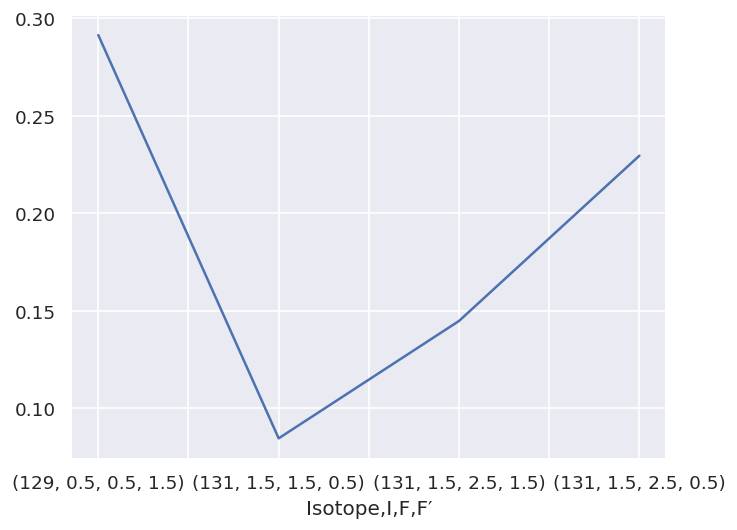

In [64]:
import hvplot.pandas
xePropsFit['Splitting/cm−1'].plot()

In [105]:
xePropsFit.index.values

array([(129, 0.5, 0.5, 1.5), (131, 1.5, 1.5, 0.5), (131, 1.5, 2.5, 1.5),
       (131, 1.5, 2.5, 0.5)], dtype=object)

In [107]:
# xePropsFit['Splitting/cm−1'].hvplot()  # No multindex support...?

# Ah, probably need to flatten - should have code elsewhere for this.
# Quick go per https://stackoverflow.com/questions/74860179/hvplot-interactive-pd-dataframe-with-multiindex
# Fails for Series... except with names only... can't recall how to fix this right now...
dataPlot = xePropsFit['Splitting/cm−1'].set_axis(map(" ".join, xePropsFit.index.names), axis=0)
# dataPlot = xePropsFit['Splitting/cm−1'].set_axis(map(" ".join, qnDF.columns), axis=0)

# qnDF['F']
# dataPlot = xePropsFit.set_axis(map(" ".join, xePropsFit.index.values), axis=1)
dataPlot.hvplot()

:Curve   [index]   (Splitting/cm−1)

In [51]:
(xePropsFit.loc[(129), 'Splitting/cm−1']/xePropsFit.loc[(129)].index.to_frame()['F′']).values

array([0.19417535])

In [45]:
# xePropsFit.loc[(129)].index[0]
xePropsFit.loc[(129)].index.to_frame()['F']

I    F    F′ 
0.5  0.5  1.5    5.0
Name: F, dtype: float64

In [55]:
xeProps

A/MHz      B/MHz   Splitting/cm−1
Isotope I   F   F′                                        
129     0.5 0.5 1.5  -5723+/-9  nan+/-nan  0.2863+/-0.0005
131     1.5 1.5 0.5  1697+/-30     -8+/-7  0.0855+/-0.0010
            2.5 1.5  1697+/-30     -8+/-7  0.1411+/-0.0029
                0.5  1697+/-30     -8+/-7  0.2276+/-0.0029

## SCRATCH

In [7]:
xeProps['A/MHz']

Isotope  I    F    F′ 
129      0.5  0.5  1.5    -5723+/-9
131      1.5  1.5  0.5    1697+/-30
              2.5  1.5    1697+/-30
                   0.5    1697+/-30
Name: A/MHz, dtype: object

In [11]:
xeProps.xs((131,1.5,1.5,0.5))

A/MHz                   1697+/-30
B/MHz                      -8+/-7
Splitting/cm−1    0.0855+/-0.0010
Name: (131, 1.5, 1.5, 0.5), dtype: object

In [12]:
xeProps.to_xarray()

<xarray.Dataset>
Dimensions:         (Isotope: 2, I: 2, F: 3, F′: 2)
Coordinates:
  * Isotope         (Isotope) int64 129 131
  * I               (I) float64 0.5 1.5
  * F               (F) float64 0.5 1.5 2.5
  * F′              (F′) float64 0.5 1.5
Data variables:
    A/MHz           (Isotope, I, F, F′) object nan -5723+/-9 ... 1697+/-30
    B/MHz           (Isotope, I, F, F′) object nan nan+/-nan ... -8+/-7 -8+/-7
    Splitting/cm−1  (Isotope, I, F, F′) object nan ... 0.1411+/-0.0029